# System Temperature Diagnostics
### Imports

In [1]:
import redis
import subprocess
import os
import re
import numpy as np
from astropy.time import Time
import json
import pandas as pnd
import matplotlib.pyplot as plt

### Helper Functions

In [2]:
#Start times of different periods
A19 = Time('2019-02-01T00:00:00',format='isot')
B19 = Time('2019-08-01T00:00:00',format='isot')
A20 = Time('2020-02-01T00:00:00',format='isot')
B20 = Time('2020-08-01T00:00:00',format='isot')
A21 = Time('2021-02-01T00:00:00',format='isot')
def getTemp(mjd):
    t = Time(float(mjd),format='mjd')
    #year = int(str(t.utc.iso).split("-")[0])
    tag = "21A"
    if t<A19:
        print("too early")
        return
    elif t<B19:
        tag = "19A"
    elif t<A20:
        tag = "19B"
    elif t<B20:
        tag = "20A"
    elif t<A21:
        tag = "20B"
    h = 'localhost'
    p = 6379
    r = redis.Redis(host=h,port=p,db=0)
    keys = r.hkeys("OREO_TSYS_"+tag)
    times = [toTime(k.decode("utf-8")) for k in keys]
    diff = [abs(time - t) for time in times]
    i = np.argmin(diff)
    if diff[i]>.5:
        return
    key = keys[i]
    result = toDict(r.hget("OREO_TSYS_"+tag,key))
    return result
def toTime(dateString):
    newStr = dateString[:4]+"-"+dateString[4:6]+"-"+dateString[6:11]+":"+dateString[11:13]+":"+dateString[13:15]
    print(newStr)
    return Time(newStr, format = 'isot',scale='utc')
def toDict(result):
    result = str(result)
    result = result.split(",")
    result = '{"reciever":"' + result[0].split(":")[-1] +'",'+' ,'.join(result[1:])[:-1]
    if result[-1]!="}":
        result = result + "}"
    #print(result)
    result = eval(result)
    return result
def graphHistogram(data,bins='auto',title='Histogram',label=None,density = False):
   
    n, bins, patches = plt.hist(x=data, bins=bins, alpha=0.75,rwidth=.95,label=label,density = density)
    if label:
        plt.legend()
    plt.grid(axis='y', alpha=0.9)
    plt.xlabel('Temp (K)')
    plt.ylabel('Frequency')
    plt.title(title)
    #plt.ylim(top=np.ceil(n.max() / 10) * 10)
    
def graphPie(data,colors=['green','orange','red'],labels=['Good','Poor','Bad']):
    if False: #For more general purpose graphing, not currently used
        plt.pie(data, labels = labels,colors = colors) 
    else:
        newData = []
        newData.append(data[data['maxTemp']<2**.5*data['target']].shape[0])
        newData.append(data[data['maxTemp']<2*data['target']].shape[0]-newData[0])
        newData.append(data[data['maxTemp']>=2*data['target']].shape[0])
        plt.pie(newData, labels = labels,colors= colors)
recieverToBand = {"Rcvr1_2":"L","Rcvr2_3":"S","Rcvr4_6":"C","Rcvr8_10":"X","Rcvr8_12":"X",'Rcvr12_18':"Ku",'RcvrArray18_26':"K"}

    
    
toBand = np.vectorize(lambda x: recieverToBand[x])

### Loading Data

In [67]:
h = 'localhost'
p = 6379
r = redis.Redis(host=h,port=p,db=0)
dicts = []
for tag in ["19A","19B","20A","20B"]:
    keys = r.hkeys("OREO_TSYS_"+tag)
    results = [r.hget("OREO_TSYS_"+tag,key) for key in keys]
    dicts.extend([toDict(result) for result in results])
data = pnd.DataFrame(dicts)
#data['maxTemp'] = np.vectorize(max)(data['measured'])
data['maxTemp'] = [d[1] for d in data['measured']]
data['band'] =toBand(data['reciever'])
data['target'] = [0]*data.shape[0] #Initializing target, updated below based on table 2.2 in GBTog.pdf
data.loc[data['band']=='L','target']=20
data.loc[data['band']=='S','target']=22
data.loc[data['band']=='C','target']=18
data.loc[data['band']=='X','target']=27
data.loc[data['band']=='Ku','target']=30
data.loc[data['band']=='K','target']=45 #Unsure on the accuracy of this value, a range is given in the table
Ldata = data[data['band'] == 'L']

Sdata = data[data['band']=='S']
Cdata = data[data['band']=='C']
Xdata = data[data['band'] == 'X']
Kudata = data[data['band'] == 'Ku']
Kdata = data[data['band'] == 'K']
data

,reciever,freq,elev,forecast,measured,maxTemp,band,target
0,Rcvr8_10,9.375,29.96,31.4,"[47.1, 49.0]",49.0,X,27
1,Rcvr8_10,9.375,36.04,28.4,"[28.0, 29.6]",29.6,X,27
2,Rcvr8_10,9.375,43.68,27.9,"[27.6, 28.1]",28.1,X,27
3,Rcvr8_10,9.375,73.04,28.0,"[35.2, 34.9]",34.9,X,27
4,Rcvr8_10,9.375,29.60,29.8,"[29.6, 30.3]",30.3,X,27
...,...,...,...,...,...,...,...,...
964,Rcvr4_6,6.500,43.04,19.8,"[25.7, 22.0]",22.0,C,18
965,Rcvr8_10,9.375,34.34,26.9,"[36.8, 32.4]",32.4,X,27
966,Rcvr8_10,9.375,46.98,24.2,"[33.2, 32.3]",32.3,X,27
967,Rcvr2_3,2.400,23.91,16.9,"[19.9, 18.6]",18.6,S,22


### Histogram Results
#### a) Single Source Results (Overview)
These graphs are to give a general overview of the distributions for tempX and tempY in the different bands as well as overall.

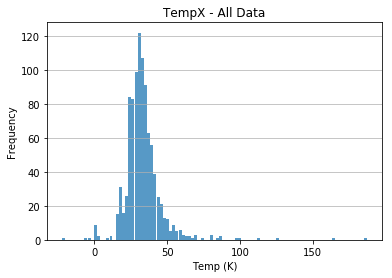

In [4]:
tempX = np.array([d[0] for d in data['measured']])
tempY = np.array([d[1] for d in data['measured']])
graphHistogram(tempX,title='TempX - All Data')

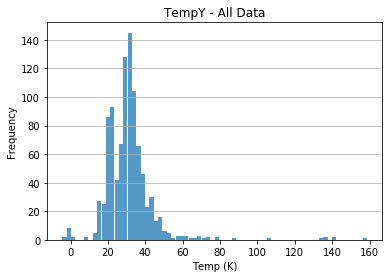

In [5]:
graphHistogram(tempY,title='TempY - All Data')

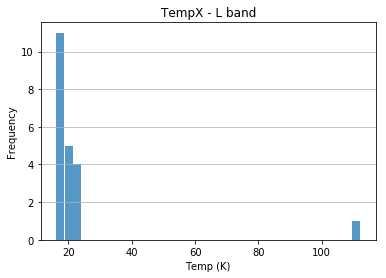

In [6]:
tempLX = np.array([d[0] for d in Ldata['measured']])
#tempLX = tempLX[tempLX <50]
tempLY = np.array([d[1] for d in Ldata['measured']])
graphHistogram(tempLX,title='TempX - L band')

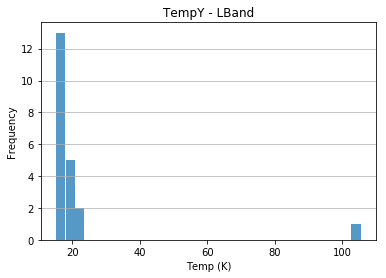

In [7]:
graphHistogram(tempLY,title='TempY - LBand')

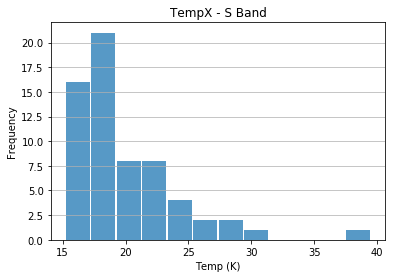

In [8]:
tempSX = np.array([d[0] for d in Sdata['measured']])
tempSY = np.array([d[1] for d in Sdata['measured']])
graphHistogram(tempSX,title='TempX - S Band')

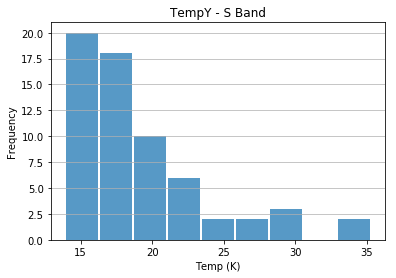

In [9]:
graphHistogram(tempSY,title='TempY - S Band')

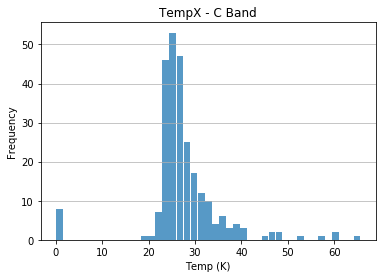

In [10]:
tempCX = np.array([d[0] for d in Cdata['measured']])
tempCY = np.array([d[1] for d in Cdata['measured']])
graphHistogram(tempCX,title='TempX - C Band')


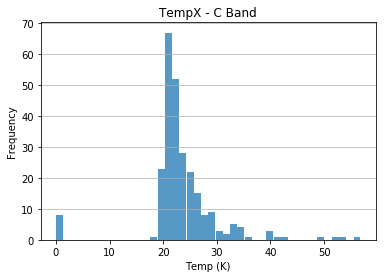

In [11]:
graphHistogram(tempCY,title='TempX - C Band')

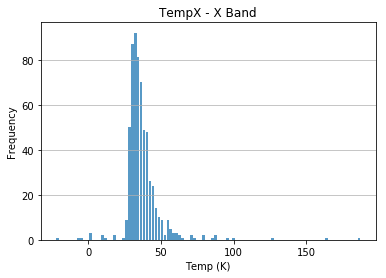

In [12]:
tempXX = np.array([d[0] for d in Xdata['measured']])
tempXY = np.array([d[1] for d in Xdata['measured']])
graphHistogram(tempXX,title='TempX - X Band')

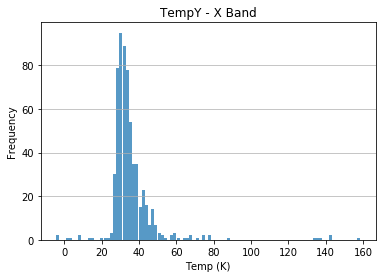

In [13]:
graphHistogram(tempXY,title='TempY - X Band')

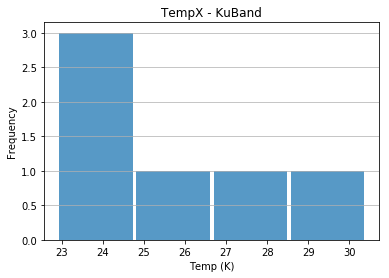

In [14]:
tempKuX = np.array([d[0] for d in Kudata['measured']])
tempKuY = np.array([d[1] for d in Kudata['measured']])
graphHistogram(tempKuX,title='TempX - KuBand')

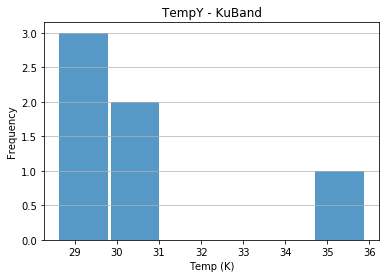

In [15]:
graphHistogram(tempKuY,title='TempY - KuBand')

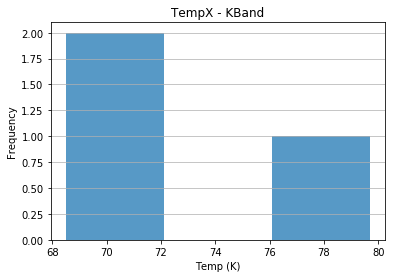

In [16]:
tempKX = np.array([d[0] for d in Kdata['measured']])
tempKY = np.array([d[1] for d in Kdata['measured']])
graphHistogram(tempKX,title='TempX - KBand')

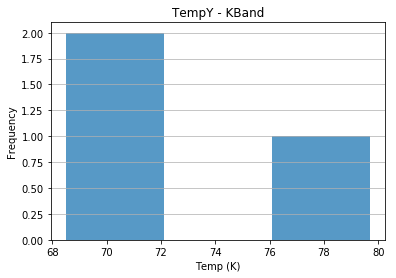

In [17]:
graphHistogram(tempKX,title='TempY - KBand')

#### b) Comparisons
This section is for comparing different data, it mostly consists of multiple histograms graphed on the same graph and difference histograms.

##### i) Comparisons of TempX and TempY

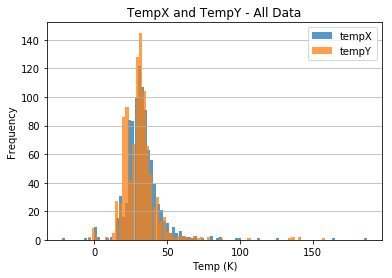

In [18]:
graphHistogram(tempX,label='tempX')
graphHistogram(tempY,title='TempX and TempY - All Data',label='tempY')

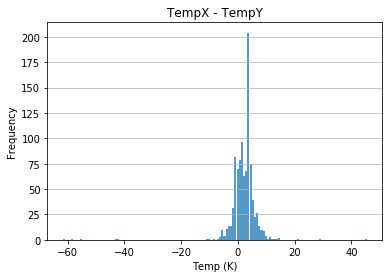

In [19]:
diff = tempX - tempY
#|diff = diff[abs(diff)<10]
graphHistogram(diff, title = 'TempX - TempY')

In [20]:
print("On average tempX is %2.2f degrees hotter than tempY. The average difference between them is %2.2f degrees. The max amount tempX is larger than tempY is %2.2f degrees while the most tempY is larger than tempX is %2.2f."%(np.mean(tempX-tempY),np.mean(np.abs(tempX-tempY)),np.max(tempX-tempY),np.max(tempY-tempX)))

On average tempX is 2.10 degrees hotter than tempY. The average difference between them is 3.41 degrees. The max amount tempX is larger than tempY is 45.50 degrees while the most tempY is larger than tempX is 61.80.


Looking at this data if we ignore the outliers it does seem that tempX and tempY are generally pretty close together, with tempX being higher on average. Since higher temperatures are ususually more concering it makes sense to define a temperature statistic which is simply the max between tempX and tempY. Below is also a quick check to see if these statistics vary substantially based on band (ignoring Ku and K due to lack of data). 

In [21]:
print("On average tempLX is %2.2f degrees hotter than tempLY. For S band this is %2.2f degrees, C band is %2.2f degrees, and X band is %2.2f degrees."%(np.mean(tempLX-tempLY),np.mean(tempSX-tempSY),np.mean(tempCX-tempCY),np.mean(tempXX-tempXY)))
print("The average differences for these are %2.2f, %2.2f, %2.2f, and %2.2f degrees for L,S,C and X bands respectively"%(np.mean(np.abs(tempLX-tempLY)),np.mean(np.abs(tempSX-tempSY)),np.mean(np.abs(tempCX-tempCY)),np.mean(np.abs(tempXX-tempXY))))

On average tempLX is 1.17 degrees hotter than tempLY. For S band this is 0.91 degrees, C band is 4.05 degrees, and X band is 1.49 degrees.
The average differences for these are 1.17, 1.63, 4.05, and 3.36 degrees for L,S,C and X bands respectively


There is one surprising thing about the above results, The temp difference is much higher for C band on average, and it seems to always have tempX > tempY. This is plotted below.

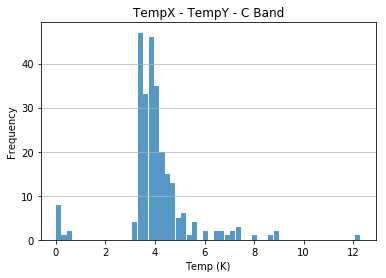

In [22]:
graphHistogram(tempCX-tempCY,title = 'TempX - TempY - C Band')

##### ii) Band differences
This section is focused on looking at differences in max temperature between the different bands. 

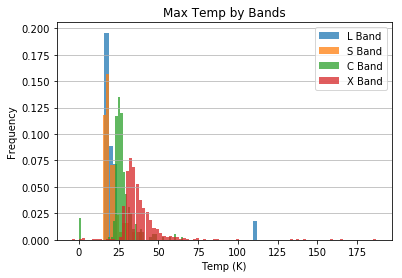

In [23]:
graphHistogram(Ldata['maxTemp'],label="L Band",density=True)
graphHistogram(Sdata['maxTemp'],label="S Band",density=True)
graphHistogram(Cdata['maxTemp'],label = "C Band",density=True)
#graphHistogram(Kudata['maxTemp'],label = "Ku Band",density=True)
#graphHistogram(Kdata['maxTemp'],label = "K Band",density=True)
graphHistogram(Xdata['maxTemp'],label = "X Band", title = "Max Temp by Bands",density=True)

Discounting L band we mostly see the results we would expect, Temp for X band is higher than the C band which in turn is higher than the X band. L band data however appears to be much more variable and doesnt necessarily fit the pattern. To investigate further below I print out the average value of these max temperatures.

In [24]:
print("L band: %2.2f K, S band: %2.2f K, C band: %2.2f K, X band: %2.2f K"%(np.mean(Ldata['maxTemp']),np.mean(Sdata['maxTemp']),np.mean(Cdata['maxTemp']),np.mean(Xdata['maxTemp'])))

L band: 23.30 K, S band: 20.32 K, C band: 27.51 K, X band: 38.09 K


As we saw before, S C and X all follow the pattern we would expect them to, but the L band data on top of the variablity seen above is actually operating at temperatures between that of the S and C band, rather than lower than the S band as we might expect. 

##### iii) Forecast Accuracy
In this section we analyze the forecasted temperature vs max temperature (since it is the higher temperatures that are of more concern).

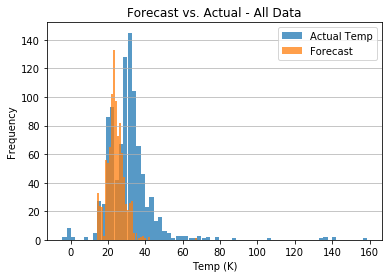

In [48]:
#data['maxTemp'] = np.vectorize(min)(data['measured'])
#data['maxTemp'] = np.vectorize(max)(data['measured'])
data['maxTemp'] = tempY
graphHistogram(data['maxTemp'],label = "Actual Temp")
graphHistogram(data['forecast'],label='Forecast',title="Forecast vs. Actual - All Data")

It seems that forecasts seem to consistently underestimate the true temperature values, but this will be examined further below.

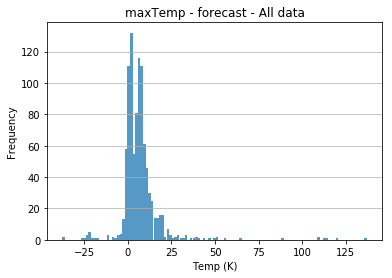

In [68]:
graphHistogram(data['maxTemp']-data['forecast'],title = "maxTemp - forecast - All data")

In [69]:
print("On average the actual temperature is %2.2f K higher than forecasted. Additionally %d/%d of the forecasts were underestimates."%(np.mean(data['maxTemp'] - data['forecast']),np.shape(data[data['maxTemp']>data['forecast']])[0],np.shape(data)[0]))

On average the actual temperature is 7.03 K higher than forecasted. Additionally 855/969 of the forecasts were underestimates.


The next question to ask is whether any of this is band dependent, so repeating the analysis for different bands:

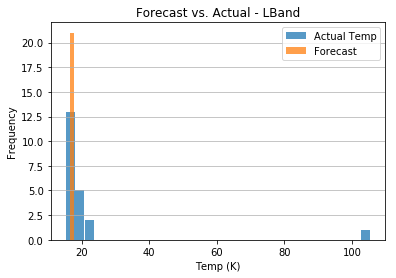

In [70]:
graphHistogram(Ldata['maxTemp'],label = "Actual Temp")
graphHistogram(Ldata['forecast'],label='Forecast',title="Forecast vs. Actual - LBand")

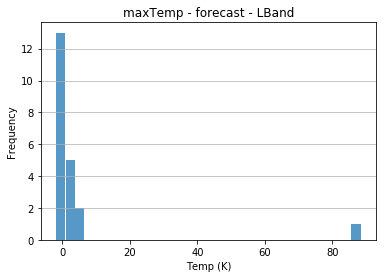

In [71]:
graphHistogram(Ldata['maxTemp']-Ldata['forecast'],title = "maxTemp - forecast - LBand")

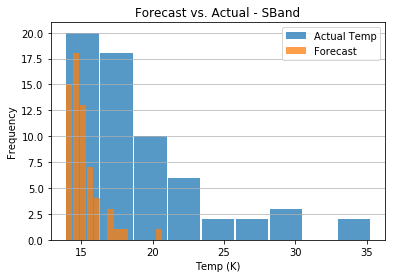

In [72]:
graphHistogram(Sdata['maxTemp'],label = "Actual Temp")
graphHistogram(Sdata['forecast'],label='Forecast',title="Forecast vs. Actual - SBand")

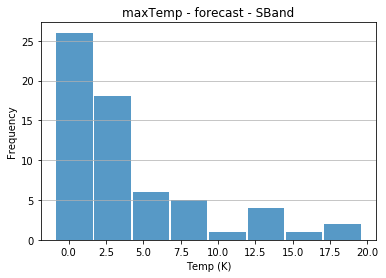

In [73]:
graphHistogram(Sdata['maxTemp']-Sdata['forecast'],title = "maxTemp - forecast - SBand")

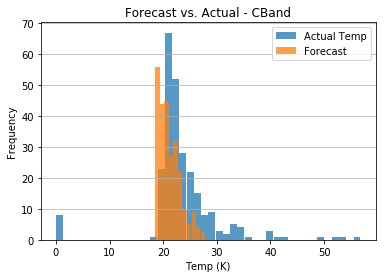

In [74]:
graphHistogram(Cdata['maxTemp'],label = "Actual Temp")
graphHistogram(Cdata['forecast'],label='Forecast',title="Forecast vs. Actual - CBand")

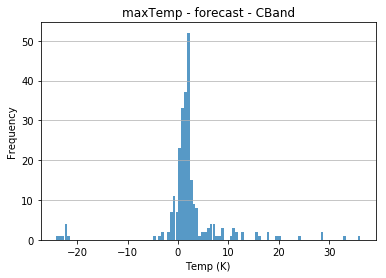

In [75]:
graphHistogram(Cdata['maxTemp']-Cdata['forecast'],title = "maxTemp - forecast - CBand")

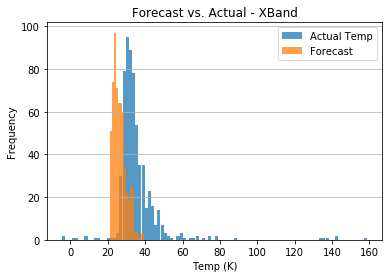

In [76]:
graphHistogram(Xdata['maxTemp'],label = "Actual Temp")
graphHistogram(Xdata['forecast'],label='Forecast',title="Forecast vs. Actual - XBand")

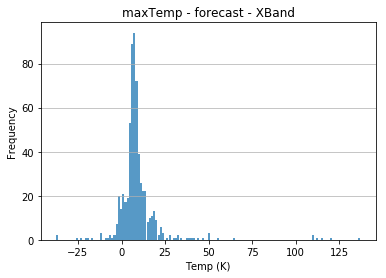

In [77]:
graphHistogram(Xdata['maxTemp']-Xdata['forecast'],title = "maxTemp - forecast - XBand")

Looking at the above graphs it is pretty clear that accross all the bands forecast is still almost always an underestimate, but some things still stand out. For instance there is 0 cases in the C band data where forecast was not an underestimate while this was not the case of the other bands (besides potentially L band which was pretty close). A final analysis of this difference is given below:

In [78]:
print("The average temperature difference between actual temp and forecast is %2.2f K for L band, %2.2f K for S band, %2.2f K for C band and %2.2f K for X band."%(np.mean(Ldata['maxTemp']-Ldata['forecast']),np.mean(Sdata['maxTemp']-Sdata['forecast']),np.mean(Cdata['maxTemp']-Cdata['forecast']),np.mean(Xdata['maxTemp']-Xdata['forecast'])))

The average temperature difference between actual temp and forecast is 5.02 K for L band, 3.95 K for S band, 2.29 K for C band and 9.35 K for X band.


The temperature difference is on average the highest for Xband data, but it is also the data with the highest temperatures and as we can see in the above graphs also potentially suffers from outliers. Below we examine medians and relative averages to account for it.

In [79]:
print("The median temperature difference between actual temp and forecast is %2.2f K for L band, %2.2f K for S band, %2.2f K for C band and %2.2f K for X band."%(np.median(Ldata['maxTemp']-Ldata['forecast']),np.median(Sdata['maxTemp']-Sdata['forecast']),np.median(Cdata['maxTemp']-Cdata['forecast']),np.median(Xdata['maxTemp']-Xdata['forecast'])))
print("The relative average temperature difference between actual temp and forecast is %2.2f %% for L band, %2.2f %% for S band, %2.2f %% for C band and %2.2f %% for X band."%(100*np.mean((Ldata['maxTemp']-Ldata['forecast'])/Ldata['forecast']),100*np.mean((Sdata['maxTemp']-Sdata['forecast'])/Sdata['forecast']),100*np.mean((Cdata['maxTemp']-Cdata['forecast'])/Cdata['forecast']),100*np.mean((Xdata['maxTemp']-Xdata['forecast'])/Xdata['forecast'])))

The median temperature difference between actual temp and forecast is 0.40 K for L band, 2.50 K for S band, 1.70 K for C band and 7.40 K for X band.
The relative average temperature difference between actual temp and forecast is 29.38 % for L band, 26.47 % for S band, 11.40 % for C band and 37.58 % for X band.


Overall with all of this it appears that forecasts are inaccurate a lot of the time and that this innacuracy is by the far the worst for X band data, even accounting for relative percentages and outliers. 

#### c) Current Categorizations
This section is to examine how many data points in each band fit into the current green, orange, and red classification used by the BTL team.

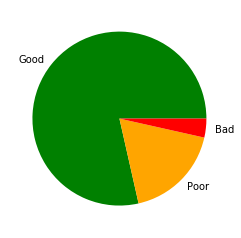

In [80]:
graphPie(data)

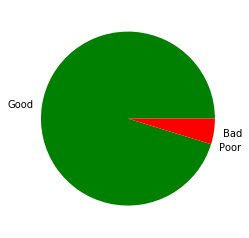

In [81]:
graphPie(Ldata)

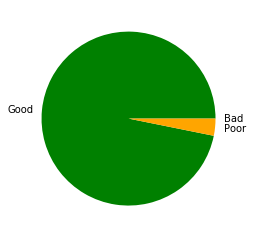

In [82]:
graphPie(Sdata)

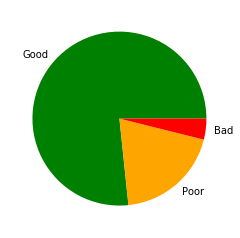

In [83]:
graphPie(Cdata)

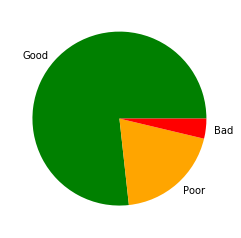

In [84]:
graphPie(Xdata)

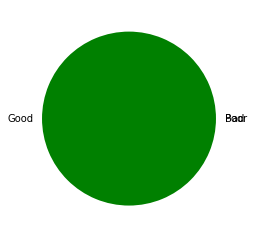

In [85]:
graphPie(Kudata)

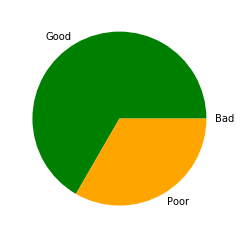

In [86]:
graphPie(Kdata)